In [1]:
import pandas as pd
import yaml
import numpy as np
from datetime import date
import os
import time
import sparse

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

import matplotlib.pyplot as plt
from scipy import signal
from src.sim_utils_Jax import *
from src.plot_utils import *
#import src.vncNetParallel as vncNetParallel
#import src.vncNetTest as vncNetTest

import jax.numpy as jnp
from jax import vmap
import jax.random as random
from jax.lax import div

### Load Rs

In [2]:
paramToIter = 'stdvProp'
stimNeuron = 1400
#basePath = f'20250227_mancBDN2activation_{paramToIter}_sweep'
#basePath = '20250227_fancBDN2activation'
#basePath = f'20250407_mancBDN2activation_{paramToIter}_stdv_sweep'
#basePath = f'20250407_mancDNb08_{stimNeuron}_activation_stimI_sweep'
#basePath = '20250225_mancBDN2activation'
basePath = '20250416_mancBDN2activation_W_50_noise'
baseDir = '/data/users/jkl/vnc-closedloop/results/jax/'
#baseDir = '/data/users/jkl/vnc-closedloop/finalResults/'

#For iterating through screen
batchStart = 1
batchEnd = 10
step = 1

batches = np.arange(batchStart, batchEnd+step, step)
print(batches)
nBatches = len(batches)
paramMeans = np.zeros(nBatches)

#Load first set of Rs - fencepost loop
loadDir = baseDir + basePath + '/' + basePath + f'_0{batchStart}/'
RsPath = loadDir + 'Rs.npz'
Rs = Rs = sparse.load_npz(RsPath).todense()
params = load_from_yaml(loadDir+'params.yaml')
paramMeans[0] = params[f"{paramToIter}"]
seeds = params["seed"]
param = get_sampled_param(params, paramToIter=paramToIter)

print(Rs.shape)

#Load rest of Rs
for i in batches[1:]:

    #Correct i for BDN2 R gain sweep
    """
    print(i)
    i = np.round(i, 2)
    if i == 0.10:
        i = 0.1
    """

    #Concatenate Rs
    if i < 10:
        loadDir = baseDir + basePath + '/' + basePath + f'_0{i}/'
    else:
        loadDir = baseDir + basePath + '/' + basePath + f'_{i}/'
    RsPath = loadDir + 'Rs.npz'
    Rs = np.concatenate((Rs, sparse.load_npz(RsPath).todense()))

    #Concatenate Params
    paramPath = loadDir + 'params.yaml' #In case we want to load params as well
    params = load_from_yaml(loadDir+'params.yaml')
    print(i-batchStart)
    paramMeans[i-batchStart] = params[f"{paramToIter}"]
    #param = np.concatenate((param, get_sampled_param(params, paramToIter=paramToIter)))
    seeds = np.concatenate((seeds, params["seed"]))

    print(Rs.shape, param.shape)

print(Rs.shape)

[ 1  2  3  4  5  6  7  8  9 10]
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


(90, 4561, 2000)
1
(180, 4561, 2000) (90, 4561)
2
(270, 4561, 2000) (90, 4561)
3
(360, 4561, 2000) (90, 4561)
4
(450, 4561, 2000) (90, 4561)
5
(540, 4561, 2000) (90, 4561)
6
(630, 4561, 2000) (90, 4561)
7
(720, 4561, 2000) (90, 4561)
8
(810, 4561, 2000) (90, 4561)
9
(900, 4561, 2000) (90, 4561)
(900, 4561, 2000)


##### Reset Size Adjustments

In [3]:
wTable = pd.read_csv(params["dfPath"],index_col=0)

#FANC has different size variable name
if "size" in wTable:
    sizes = wTable["size"]
else:
    sizes = wTable["surf_area_um2"]

normSize = np.nanmedian(sizes) #np.nanmean(sizes)
sizes[sizes.isna()] = normSize
sizes[sizes == 0] = normSize #TODO this isn't great
sizes = sizes/normSize
sizes = np.asarray(sizes)

#Set a back to original
#param = param * sizes 

#Set threshold back to original
param = param / sizes

/tmp/ipykernel_4050645/1466026096.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/tmp/ipykernel_4050645/1466026096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


##### Plot Circuit

In [ ]:
for i in range(len(Rs[0])):
    plt.plot(Rs[4, i])
#plt.plot(Rs[404, stimNeuron])

plt.title('Example FANC Run, All Neurons')
plt.xlabel('time (ms)')
plt.ylabel('Firing Rate')


NameError: name 'Rs' is not defined

Index([31, 277, 617, 1165], dtype='int64')
0.5


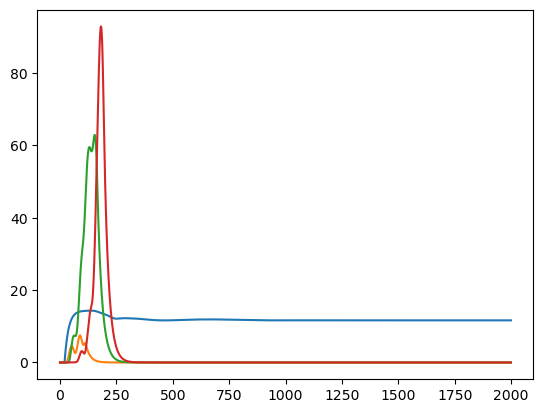

In [20]:
wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMnsL = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
print(nonMnsL.index)
#plot_R_traces(Rjax,nonMns,activeOnly=False)
"""
index	bodyId	type
132	10339	BDN2
273	10690	IN17A001
1119	13698	IN15A001
1218	14096	IN16B007
"""

nonMnsR = wTable.loc[(wTable["bodyId"]==10339) | (wTable["bodyId"]==10690) | (wTable["bodyId"]==13698) | (wTable["bodyId"]==14096)]

j = 0
print(paramMeans[j])
for i in nonMnsL.index:
    plt.plot(Rs[j*90 + 8,i])

##### Calculate Oscillation Scores

In [3]:
#Get neurons we want to calculate oscillation scores on
wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index
inLIdxs = wTable.loc[(wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)].index
inRIdxs = wTable.loc[(wTable["bodyId"]==10690) | (wTable["bodyId"]==13698) | (wTable["bodyId"]==14096)].index

print(len(Rs))

#Calculate oscillation scores
oscillationScores = np.zeros(len(Rs)) 
for i in range(len(Rs)):
    R = Rs[i]
    maxFrs = np.max(R,axis=1)
    activeMnIdxs = mnIdxs[np.where(maxFrs[mnIdxs]>0)]  
    oscillationScores[i] = sim_oscillation_score(R,activeMnIdxs,1000,2000)

    #Just to keep track of progress
    if i % 100 == 0:
        print(i)

900
0


/home/jkl/miniconda3/envs/vnc-closedloop/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jkl/miniconda3/envs/vnc-closedloop/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jkl/vnc-closedloop/src/sim_utils_Jax.py:86: RuntimeWarning: invalid value encountered in divide
  activity = 2 * activity/np.max(activity) - 1


100
200
300
400
500
600
700
800


##### Plot Oscillation Scores

Text(0.5, 1.0, 'Impact of Weight Matrix Noise on Oscillation Scores')

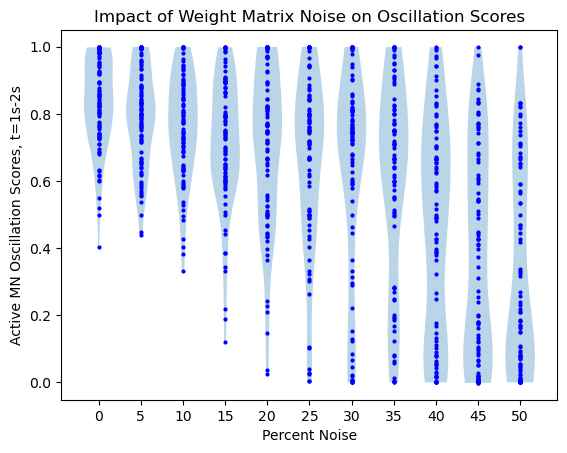

In [34]:
o_tabular = np.zeros((11, 90))
xticks = np.zeros(11, dtype=int)
for i in range(11):
    o_tabular[i] = oscillationScores[i*90:(i+1)*90]
    xticks[i] = i*5

#print(oscillationScores)

plt.violinplot(o_tabular.T, showextrema=False, widths=0.7)
#plt.plot(o_tabular, '.')
plt.xticks(np.arange(1, len(xticks) + 1), labels=xticks)
for i, oBatch in enumerate(o_tabular, start = 1):
    plt.plot(np.full(len(oBatch), i), oBatch, 'o', markersize=2, color='b')

plt.xlabel('Percent Noise')
plt.ylabel('Active MN Oscillation Scores, t=1s-2s')
plt.title('Impact of Weight Matrix Noise on Oscillation Scores')

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5


Text(0.5, 1.0, 'Impact of Weight Matrix Noise on Oscillation Scores')

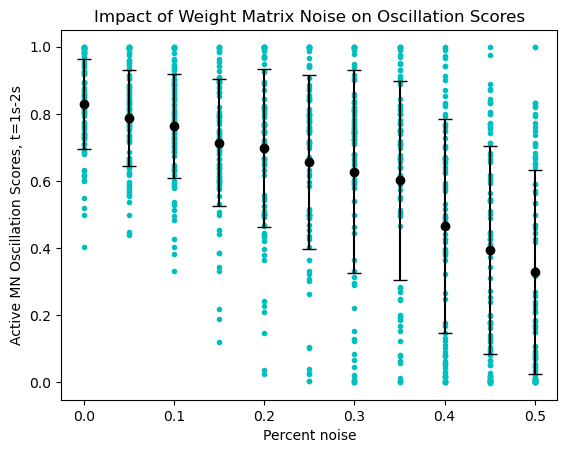

In [5]:
a_arr = np.zeros(990)
for i in range(11):
    a = i*0.05
    start = i*90
    end = (i+1)*90
    a_arr[start:end] = a
    print(a)

plt.plot(a_arr, oscillationScores, '.', color='c')
plt.errorbar(paramMeans, means, yerr=stdvs, capsize=5, fmt='o', color = 'k')
#plt.xlabel(f'DNb08 {paramToIter}')
plt.ylabel('Active MN Oscillation Scores, t=1s-2s')
#plt.title(f'End Sim oscillation Scores vs. DNb08 - ID{stimNeuron} {paramToIter}')

plt.xlabel('Percent noise')
plt.title('Impact of Weight Matrix Noise on Oscillation Scores')

In [13]:
print(np.where(oscillationScores < 0.1))

(array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   41,   42,   43,   44,   45,
         47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
         58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,
         91,   92,   93,   94,   95,   96,   97,   98,   99,  100,  101,
        104,  105,  106,  107,  108,  109,  110,  111,  112,  113,  114,
        115,  117,  118,  119,  120,  121,  123,  125,  126,  127,  128,
        129,  130,  131,  132,  133,  134,  135,  136,  137,  139,  140,
        142,  143,  144,  145,  146,  147,  148,  149,  150,  151,  152,
        154,  155,  156,  157,  158,  159,  160,  

##### Plot statistics by batch

990
1 0.0 0.8288110990171424
2 0.0 0.7880098311150372
3 0.0 0.7635292981308044
4 0.0 0.71401611856785
5 0.022222222222222223 0.6986034276924765
6 0.05555555555555555 0.6568331398631416
7 0.12222222222222222 0.628159451005986
8 0.1 0.6017989455572358
9 0.23333333333333334 0.46484867457449963
10 0.2777777777777778 0.39480665827302275
11 0.36666666666666664 0.3292623687556945


Text(0.5, 1.0, 'Mean Oscillation Scores by Weight Matrix Noise')

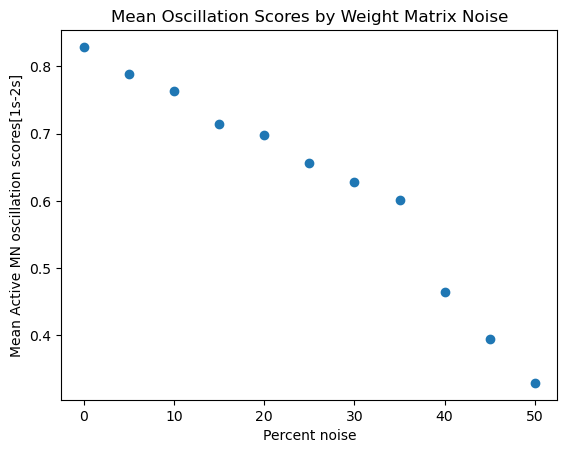

In [35]:
print(len(oscillationScores))
p_dead = np.zeros(len(batches))
means = np.zeros(len(batches))
stdvs = np.zeros(len(batches))
for i in range(len(batches)):
    oscillation_batch = oscillationScores[i*90:i*90+90]
    p_dead[i] = len(np.where(oscillation_batch<0.1)[0])/len(oscillation_batch)
    means[i] = np.mean(oscillation_batch[np.where(oscillation_batch>=0)])
    stdvs[i] = np.std(oscillation_batch[np.where(oscillation_batch>=0)])
    print(i+1, p_dead[i], means[i])
    #print(oscillation_batch)

plt.plot(paramMeans*100, means, 'o')
#plt.errorbar(paramMeans, means, yerr=stdvs, capsize=3, fmt='o')
#plt.xlabel(f'Stdv {paramToIter}')
plt.xlabel('Percent noise')
#plt.ylabel('P(oscillation score[1s-2s]) < 0.1, Active MNs')
plt.ylabel('Mean Active MN oscillation scores[1s-2s]')
#plt.title(f'End Sim Mean Oscillation Scores vs BDN2 L {paramToIter} Stdv')
#plt.title(f'Sim Failure by Stdv {paramToIter}')
#plt.title(f'Sim Failure by Weight Matrix Noise')
plt.title('Mean Oscillation Scores by Weight Matrix Noise')


### Generate Noisy Weight Matrices

In [25]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

baseDir = '/data/users/jkl/vnc-closedloop/finalResults/'
basePath = '20250409_mancBDN2activation_W_noise'

loadDir = baseDir + basePath + '/' + basePath + '_10/'
params = load_from_yaml(loadDir+'params.yaml')
#seeds = jnp.array(params["seed"])
stdvProp = params["stdvProp"]

W = load_W(params["wPath"])

Wt_exc = jnp.maximum(W,0)
Wt_inh = jnp.minimum(W,0)
W_rw = jnp.transpose(params["excitatoryMultiplier"]*Wt_exc + params["inhibitoryMultiplier"]*Wt_inh)

#resample_vmap = vmap(vncNetTest.resample_W, in_axes=(None, 0, None))
#Ws = resample_vmap(W_rw, seeds, stdvProp)
#print(np.array(Ws).shape)

def sample_W_mini(W, seed, miniIdxs):
    key = random.key(seed)
    sample = random.truncated_normal(key, lower = div(-1.0, stdvProp), upper = float('inf'), shape=W.shape)
    #sample = random.normal(key, shape=W.shape)
    return sample[jnp.ix_(miniIdxs, miniIdxs)]
    #return sample

wTable = load_wTable(params["dfPath"])
inLIdxs = wTable.loc[(wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)].index
inRIdxs = wTable.loc[(wTable["bodyId"]==10690) | (wTable["bodyId"]==13698) | (wTable["bodyId"]==14096)].index

wTableMini = pd.read_csv("../data/MANC weights/20241118_T1Lminicircuit/wTable_20241118_T1Lminicircuit.csv",index_col=0)
print(inLIdxs)

miniIdxs = np.array(wTable[wTable["bodyId"].isin(wTableMini["bodyId"])].index)
miniIdxs = np.concatenate((miniIdxs, [132],inRIdxs))

print(len(miniIdxs))
miniW = W_rw[np.ix_(miniIdxs, miniIdxs)]
removeList = []
for i, I in enumerate(miniIdxs):
    if not np.any(miniW[i]) and not np.any(miniW[:,i]):
        #print(i)
        removeList = removeList + [I]


print(len(removeList))
miniIdxs = np.setdiff1d(miniIdxs, removeList)

#miniIdxs = np.concatenate(([31], inLIdxs, [132],inRIdxs))

samples = np.zeros((len(seeds), len(miniIdxs), len(miniIdxs)))
for i, seed in enumerate(seeds):
    #print(i*90,(i+1)*90)
    #samples[i*90:(i+1)*90] = vmap(sample_W_mini, in_axes=(None, 0, None))(W_rw, seeds[i*90:(i+1)*90], miniIdxs)
    samples[i] = sample_W_mini(W_rw, seed, miniIdxs)
    if i % 100 == 0:
        print(i)

#samples = vmap(sample_W_mini, in_axes=(None, 0, None))(W_rw, seeds, miniIdxs)
print(samples.shape)

#

Index([277, 617, 1165], dtype='int64')
127
49
0
100
200
300
400
500
600
700
800
(900, 78, 78)


In [5]:
print(np.std(samples))

0.9415065047843205


120
(900, 78, 78) 0.9418085918214426
0.945780589645486
[0.93996969 0.96381203 0.89063628 0.93658745 0.9507765  0.96359364
 0.91207498 0.89719096 0.87157626 1.02399313 0.97588354 0.99939592
 0.94648786 0.98672148 0.93889828 0.94171416 0.94695603 0.95395925
 0.90197117 0.87473424 0.92915345 0.99785958 0.98899992 0.94923304
 0.92420681 0.92513383 0.96335002 0.89113324 0.92914919 0.91328661
 0.94111529 1.02069614 0.87194784 0.94657872 0.92104682 0.94669769
 0.98539577 0.95964428 0.8907171  0.94770282 0.95634039 0.93573282
 0.87928726 0.9532689  0.90246582 0.98922019 0.93503635 1.0205398
 0.91327018 0.94473936 0.95932314 0.9474108  0.9779632  0.96152382
 0.9312628  0.93478548 0.90567095 0.85463584 0.92712684 0.90734802
 0.9259374  0.94729299 0.89675593 0.91068307 0.94118595 0.9526695
 0.93696382 0.96281853 0.92381576 0.96753843 0.94667969 0.94848065
 0.94679115 0.96198139 0.93136793 0.94734447 0.99345447 0.90183783
 0.94536881 0.97503731 1.0000118  0.87321083 0.95696885 0.89975823
 0.962469

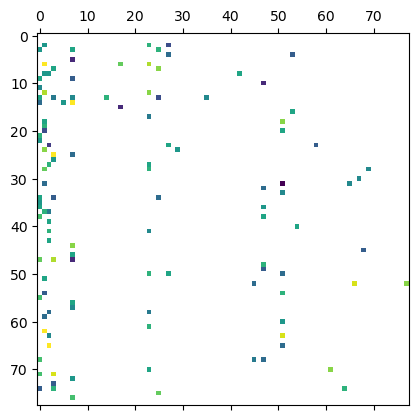

In [27]:
#wTable = load_wTable(params["dfPath"])
#inLIdxs = wTable.loc[(wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)].index
#inRIdxs = wTable.loc[(wTable["bodyId"]==10690) | (wTable["bodyId"]==13698) | (wTable["bodyId"]==14096)].index
#miniIdxs = np.concatenate(([31], inLIdxs, [132],inRIdxs))

miniW = W_rw[np.ix_(miniIdxs, miniIdxs)]
nonzeroIdxs = np.where(miniW != 0)

print(len(nonzeroIdxs[0]))

goodSims = np.where(oscillationScores > 0.5)[0]
goodStdvs = np.zeros((len(goodSims), len(miniIdxs), len(miniIdxs)))
allGood = np.zeros((len(goodSims),len(nonzeroIdxs[0])))
#print(goodSims)


print(samples.shape, np.std(samples))
for i, sim in enumerate(goodSims):
    #miniSample = samples[sim][np.ix_(miniIdxs, miniIdxs)]
    goodStdvs[i][nonzeroIdxs] = samples[sim][nonzeroIdxs]
    allGood[i] = samples[sim][nonzeroIdxs]

print(np.std(allGood))
print(np.std(allGood, axis=0))

a = np.zeros(miniW.shape)
a[nonzeroIdxs] = np.round(np.std(allGood, axis=0),2)
a[np.where(a==0)] = None
#print(a)

#print(a[104])
#print(a[:,104])


plt.matshow(a)


In [ ]:
fig, axs = plt.subplots(nrows=len(miniIdxs), ncols=len(miniIdxs), figsize=(8, 6), sharex=True, sharey=True)

for i in range(len(allGood[0])):
    ax = axs[nonzeroIdxs[0][i], nonzeroIdxs[1][i]]
    ax.violinplot(allGood[:,i], orientation="horizontal", side='high', showextrema=False)
    ax.violinplot(samples[:, nonzeroIdxs[0][i], nonzeroIdxs[1][i]], orientation="horizontal", side='high', showextrema=False)

plt.show()



KeyboardInterrupt: 

### Analyze FANC Run

In [ ]:
basePath = '20250227_fancBDN2activation'
baseDir = '/data/users/jkl/vnc-closedloop/results/jax/'

#For iterating through screen
batchStart = 0
batchEnd = 3
step = 1

batches = np.arange(batchStart, batchEnd+step, step)
print(batches)
nBatches = len(batches)
paramMeans = np.zeros(nBatches)

#Load first set of Rs - fencepost loop
loadDir = baseDir + basePath + '/' + basePath + f'_0{batchStart}/'
RsPath = loadDir + 'Rs.npz'
Rs = Rs = sparse.load_npz(RsPath).todense()
params = load_from_yaml(loadDir+'params.yaml')
paramMeans[0] = params[f"{paramToIter}"]
param = get_sampled_param(params, paramToIter=paramToIter)

print(Rs.shape)

#Load rest of Rs
for i in batches[1:]:

    #Correct i for BDN2 R gain sweep
    """
    print(i)
    i = np.round(i, 2)
    if i == 0.10:
        i = 0.1
    """

    #Concatenate Rs
    if i < 10:
        loadDir = baseDir + basePath + '/' + basePath + f'_0{i}/'
    else:
        loadDir = baseDir + basePath + '/' + basePath + f'_{i}/'
    RsPath = loadDir + 'Rs.npz'
    Rs = np.concatenate((Rs, sparse.load_npz(RsPath).todense()))

    #Concatenate Params
    paramPath = loadDir + 'params.yaml' #In case we want to load params as well
    params = load_from_yaml(loadDir+'params.yaml')
    print(i-batchStart)
    paramMeans[i-batchStart] = params[f"{paramToIter}"]
    param = np.concatenate((param, get_sampled_param(params, paramToIter=paramToIter)))

    print(Rs.shape, param.shape)

print(Rs.shape)

4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


31


Text(0.5, 1.0, 'BDN2 Gain Parameter vs Motor Neuron Oscillation Score')

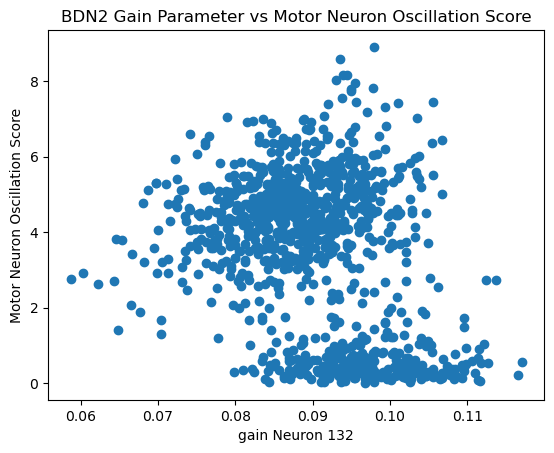

In [6]:
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)].to_numpy()[:, 0]
print(nonMns[0])

n = 132
plt.plot(a[:,n], oscillationScores, 'o')
plt.xlabel(f'gain Neuron {n}')
plt.ylabel(f'Motor Neuron Oscillation Score')
plt.title('BDN2 Gain Parameter vs Motor Neuron Oscillation Score')

In [6]:
saveDir = "../results/jax/20250214_mancBDN2activation_aSweep/20250214_mancBDN2activation_aSweep_0.1"
start = time.time()
Rs = np.load(f"{saveDir}/Rs.npy")
loadRsTime = time.time()
print(f'Time to load Rs: {loadRsTime-start}')

RsSparse = sparse.COO.from_numpy(Rs)
toSparseTime = time.time()
print(f'Time to compress: {toSparseTime-loadRsTime}')

sparse.save_npz(f'{saveDir}/Rs.npz', sparse.COO.from_numpy(Rs))

saveSparseTime = time.time()
print(f'time to save sparse matrix: {saveSparseTime-toSparseTime}')
RsNew = RsSparse.todense()
toFullTime = time.time()
print(f'time to expand: {toFullTime-saveSparseTime}')

RsSparseNew = sparse.load_npz(f'{saveDir}/Rs.npz')
loadSparseTime = time.time()
print(f'time to load sparse matrix: {loadSparseTime-toFullTime}')
Rs = sparse.load_npz(f'{saveDir}/Rs.npz').todense()
type(RsNew)
print(np.where(Rs-RsNew != 0))



Time to load Rs: 0.43196845054626465
Time to compress: 3.6467738151550293
time to save sparse matrix: 16.481002807617188
time to expand: 0.5531125068664551
time to load sparse matrix: 2.2248919010162354
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
